# Problem 1: Multiclass (30 %)

So far we have largely focused on binary classification, where the input is a document and the output is a yes or a no (or probability of yes). 

In fact, more complex tasks exist where the input is a document and the output can be multiple (more than two) classes. 

In this problem we'll investigate two so-called multiclass problems.

Multiclass: an observation is assigned inclusion in ONE of a N $N>2$ categories
 - E.g. is this sentence positive, negative, or neutral sentiment
 - E.g. is this email spam or not spam

Multiclass-multilabel: an observation can belong to more than one of $N>=2$ categories
 - E.g. is this document about `{sports, current events, Steph Curry}` ( a document can be about more than one)
 - E.g. is this blood sample A, B, O, $+$, $-$ (blood can be `A+` or `A-`)

We will study the metrics we can use to evaluate these classification problems.

In [1]:
import numpy as np
import pandas as pd
%pylab inline

import json

from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
np.random.seed(1234)

We will start with multiclass by studying the 20 newsgroups data.

## Part 0: get the data

 - Use the builtin function `from sklearn.datasets import fetch_20newsgroups`
 - NB: look at the docs and use the `remove` kwarg in order to get cleaned data

TODO
 - Fetch the data separately for the train and test data
 - How many classes are present? 
 - What is the most common class- please give the name and not the number.
 - What is the accuracy of the best constant guess in the train set?

In [3]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
# Fetch the data separately for the train and test data
data_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
print(data_train.keys())
print(data_test.keys())
print(data_train['target_names'])
print(data_train['target'][:5])
print(data_train['filenames'][:5])
print(data_train['data'][0])

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
[ 7  4  4  1 14]
['/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/rec.autos/102994'
 '/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51861'
 '/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51879'
 '/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38242'
 '/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/sci.space/60880'

In [5]:
# How many classes are present?
val_counts = np.bincount(data_train.target)
print('found {} classes'.format(val_counts.shape[0]))

# What is the most common class- please give the name and not the number.
most_common_class_index = np.argmax(val_counts)
most_common_class = data_train.target_names[most_common_class_index]
print('most common class: {}'.format(most_common_class))

# What is the accuracy of the best constant guess in the train set?
dummy_acc = accuracy_score(data_train.target, [most_common_class_index] * len(data_train.target))
print('constant guess acc: {:.3f}'.format(dummy_acc))

found 20 classes
most common class: rec.sport.hockey
constant guess acc: 0.053


## Part 1: fit a model

As we saw with mnist, logistic regression is capable of fitting multi-class data.
 - Encode the text with as a bag of words and fit logistic regression to the data
 - Calcuate the out of sample accuracy score

TODO
1. Make a count vectorizer with max_features=20000
2. Fit it
3. Transform the train and test data into number

In [6]:
vec = CountVectorizer(max_features=20000)
vec.fit(data_train.data)

# your code here
xtr = vec.transform(data_train.data) # train data
xte = vec.transform(data_test.data) # test data
print(xtr.shape, xte.shape)

(11314, 20000) (7532, 20000)


TODO
1. Fit logistic regression
2. Compute accuracy score

In [7]:
# Fit logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(xtr, data_train.target)

# Compute accuracy score
preds = lr.predict(xte)
acc = accuracy_score(data_test.target, preds)
print('Out of sample accuracy: {:.3f}'.format(acc))

Out of sample accuracy: 0.592


## Part 2: Evaluate metrics

As we have seen previously, while accuracy is useful, it does not always capture all the behavior we want in a metric.

Here we will extend the concept of f1 score to the multiclass setting. There are several ways to do this
 - Report a different f1 score for every class (no averaging)
 - Report the mean f1 score over all classes
 - Report a weighted f1 score weighted by class prevelance. 

For each of these three types of f1
 - Calculate the score(s) without the help of scikit learn
 - Compare it to the corresponding f1 score evaluated with scikit-learn (NB you'll need to read the docs for `f1_score`.) 
 - Write down the pros and cons for this method of calculating multiclass f1 score

### Option 1: different score for every class
F1 score calculated for each class separately.

In [8]:
f1s = []

for label_index, label_name in enumerate(data_train.target_names):
    # For each class, treat it as "positive" and the rest as "negative"
    y_true = (data_test.target == label_index).astype(int)  # True labels (1 for the current class, 0 for others)
    y_pred = (preds == label_index).astype(int)  # Predicted labels in a one-vs-rest manner

    # Manually calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((y_true == 1) & (y_pred == 1))  # Correctly predicted positive
    FP = np.sum((y_true == 0) & (y_pred == 1))  # Incorrectly predicted positive
    FN = np.sum((y_true == 1) & (y_pred == 0))  # Missed positive (predicted negative)

    # Calculate precision and recall manually
    if TP + FP == 0:
        precision = 0.0  # Avoid division by zero
    else:
        precision = TP / (TP + FP)
    
    if TP + FN == 0:
        recall = 0.0  # Avoid division by zero
    else:
        recall = TP / (TP + FN)
    
    # Calculate F1 score
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    # Append the F1 score for this class
    f1s.append(f1)

# Print the F1 scores for each class
for label_name, fs in zip(data_train.target_names, f1s):
    print('fscore for {} \t = {:.3f}'.format(label_name, fs))

fscore for alt.atheism 	 = 0.422
fscore for comp.graphics 	 = 0.582
fscore for comp.os.ms-windows.misc 	 = 0.560
fscore for comp.sys.ibm.pc.hardware 	 = 0.550
fscore for comp.sys.mac.hardware 	 = 0.617
fscore for comp.windows.x 	 = 0.660
fscore for misc.forsale 	 = 0.732
fscore for rec.autos 	 = 0.605
fscore for rec.motorcycles 	 = 0.631
fscore for rec.sport.baseball 	 = 0.556
fscore for rec.sport.hockey 	 = 0.810
fscore for sci.crypt 	 = 0.644
fscore for sci.electronics 	 = 0.485
fscore for sci.med 	 = 0.652
fscore for sci.space 	 = 0.628
fscore for soc.religion.christian 	 = 0.660
fscore for talk.politics.guns 	 = 0.508
fscore for talk.politics.mideast 	 = 0.657
fscore for talk.politics.misc 	 = 0.390
fscore for talk.religion.misc 	 = 0.305


In [9]:
# Compare with the built-in F1 score from sklearn
sklearn_f1s = f1_score(data_test.target, preds, average=None)
print('sklearn f1 scores:', sklearn_f1s)

# Round the F1 scores to 3 decimal places with a zero-padded format
f1s_str = ['{:.3f}'.format(fs) for fs in f1s]
print(' '.join(f1s_str))

sklearn f1 scores: [0.421875   0.58243081 0.55989583 0.54993515 0.61682243 0.66016713
 0.73232323 0.60539216 0.63133098 0.55566312 0.81019108 0.64444444
 0.4853129  0.65240642 0.62755102 0.65984655 0.50837989 0.65749656
 0.3898917  0.30522088]
0.422 0.582 0.560 0.550 0.617 0.660 0.732 0.605 0.631 0.556 0.810 0.644 0.485 0.652 0.628 0.660 0.508 0.657 0.390 0.305


Using equality is not the best for comparing decimals, changing the comparison method from what was provided. Visually above we can see they match.

In [10]:
success = np.allclose(f1s, sklearn_f1s, rtol=1e-3)
if success:
    print('sklearn builtin matches results')
else:
    print('scores do not match')

sklearn builtin matches results


- Pro: This method provides detailed performance per class, which is useful for identifying classes where the model struggles.
- Con: It can be cumbersome to interpret when dealing with many classes, as it does not provide a single summary score.

### Option 2: Mean over all classes
F1 score for each class, and then calculate the unweighted average over all classes.

In [11]:
# Manually calculate the macro-averaged F1 score
f1_macro = np.mean(f1s)  # Mean of the F1 scores across all classes - individual class F1 scores are already calculated

# Calculate the macro-averaged F1 score using scikit-learn
f1_macro_sk = f1_score(data_test.target, preds, average='macro')

# Check if the manually computed macro F1 score matches the sklearn F1 score
# Changed this from the original code to use np.isclose instead of direct comparison
assert np.isclose(f1_macro, f1_macro_sk, rtol=1e-3), "Macro F1 scores do not match"

# Print both manually computed and sklearn F1 macro scores
print('macro f1 (manual): {:.3f} \t sklearn macro f1: {:.3f}'.format(
    f1_macro, 
    f1_macro_sk
))

macro f1 (manual): 0.583 	 sklearn macro f1: 0.583


- Pro: Treats all classes equally, regardless of their frequency in the dataset.
- Con: May give misleading results when class distribution is imbalanced because rare classes have the same impact on the score as common ones.

### Option 3: Weighted mean
Classes which are more prevalent have their F1 scores count more in the resulting average.

Now weighted by class prevalence

TODO:
- Calculate the frequency of each class
- Take a weighted average of the f1s, weighted by these weights
- Compare to sklearn

In [12]:
# Calculate the weights for each class based on the number of true instances in the test set
wts = np.bincount(data_test.target) / len(data_test.target)  # Class frequencies as weights

# Manually calculate the weighted-averaged F1 score
weighted_f1 = np.sum(np.array(f1s) * wts)  # Sum of F1 scores weighted by class frequency

# Calculate the weighted-averaged F1 score using scikit-learn
weighted_f1_sk = f1_score(data_test.target, preds, average='weighted')  # Sklearn method for weighted F1 score

# Print both manually computed and sklearn weighted F1 scores
print('weighted f1 (manual): {:.3f} \t sklearn weighted f1: {:.3f}'.format(weighted_f1, weighted_f1_sk))

# Optional: Add a check to ensure the manually computed score matches sklearn's score
assert np.isclose(weighted_f1, weighted_f1_sk, rtol=1e-3), "Weighted F1 scores do not match"

weighted f1 (manual): 0.592 	 sklearn weighted f1: 0.592


- Pro: Better suited for imbalanced datasets, as it reflects the actual performance for the majority of the samples.
- Con: May overemphasize the performance on the majority classes and downplay the minority classes.

## Part 3: Confusion Matrix

The confusion matrix is a handy way to understand errors in classification problems. It is a 2-D grid of what values were predicted and what the actual values were. 

See [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) in the sklearn docs. 

Create a confusion matrix for the 20-newsgroups dataset and comment on the most common failure modes.

In [13]:
from sklearn.metrics import confusion_matrix
# your code here
# NB: it's handy to call `pd.DataFrame` on the confusion matrix to print it out nicely

# Calculate the confusion matrix
cm = confusion_matrix(data_test.target, preds)

# Convert confusion matrix to a dataframe
cm_df = pd.DataFrame(cm, index=data_train.target_names, columns=data_train.target_names)
cm_df

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,135,3,4,0,2,4,2,6,10,15,1,3,8,11,11,30,9,12,8,45
comp.graphics,3,242,17,9,10,27,10,4,5,14,2,4,17,4,10,1,1,3,2,4
comp.os.ms-windows.misc,4,31,215,41,17,15,3,7,4,19,1,7,3,6,8,0,2,4,4,3
comp.sys.ibm.pc.hardware,1,19,43,212,34,6,15,5,3,8,2,4,33,3,3,0,0,0,1,0
comp.sys.mac.hardware,0,9,13,35,231,1,15,11,8,17,6,4,22,2,7,1,2,0,1,0
comp.windows.x,0,54,40,13,4,237,7,2,2,12,0,4,4,1,7,3,1,4,0,0
misc.forsale,0,2,5,18,14,2,290,8,15,14,1,1,9,2,3,0,1,2,2,1
rec.autos,8,4,3,4,2,1,12,247,22,32,2,2,21,4,6,3,5,3,10,5
rec.motorcycles,7,4,0,3,4,1,4,32,268,22,2,3,16,5,8,0,3,5,8,3
rec.sport.baseball,8,3,0,0,3,0,5,8,13,287,29,0,4,4,9,6,2,6,7,3


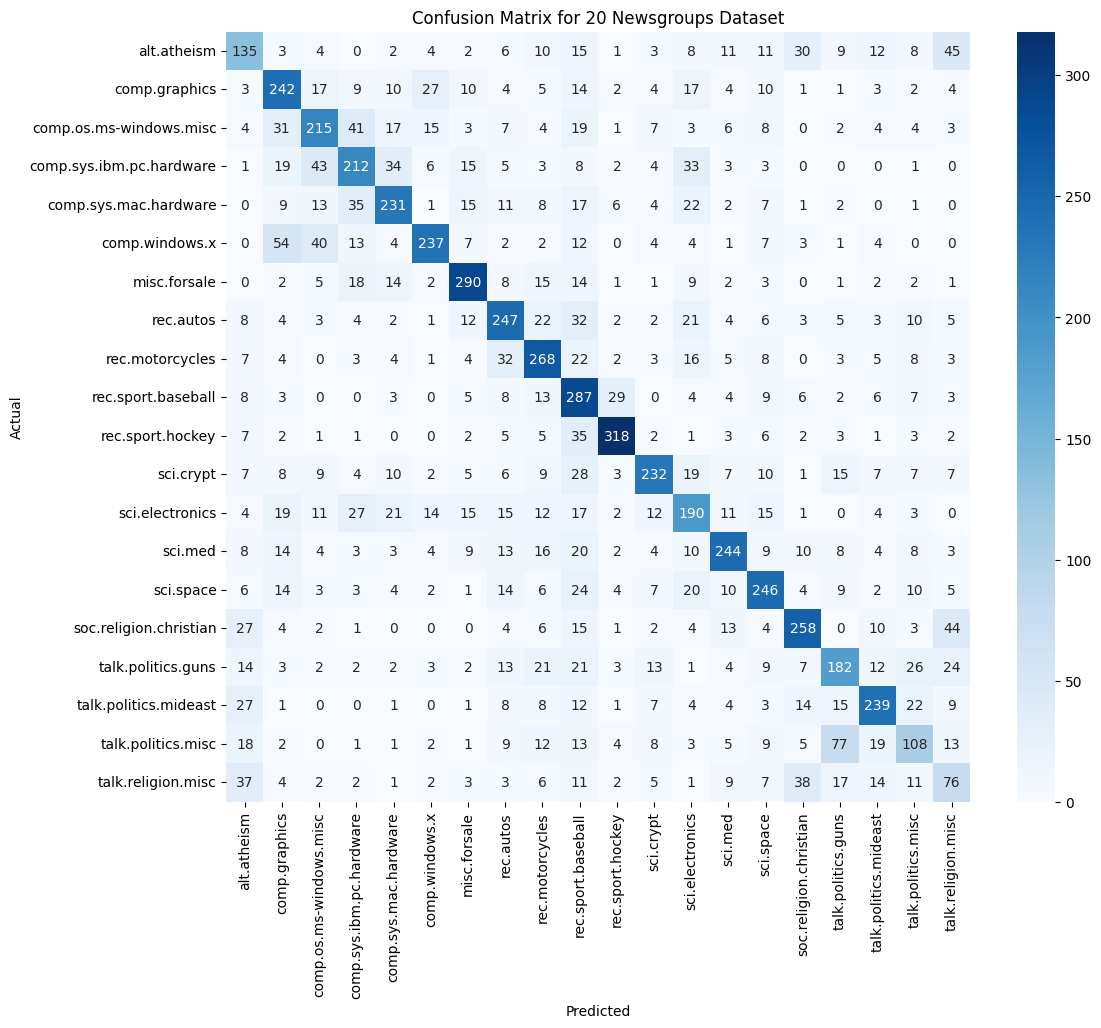

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_train.target_names, yticklabels=data_train.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 20 Newsgroups Dataset')
plt.show()

Comments on the most common failure modes.

- Similar Topic Misclassification
    - Classes that represent similar topics (e.g., comp.graphics and comp.os.ms-windows.misc or talk.politics.misc and talk.politics.guns) are likely to have high misclassification rates. This happens because the vocabulary and context are often shared between similar topics, making it harder for the model to differentiate between them.
- Overlapping Jargon
    - Groups related to computer topics (comp.*) might share technical jargon, which leads to higher confusion among those categories.
    - In subcategories within larger domains (e.g., rec.sport.baseball and rec.sport.hockey), the model might confuse these classes due to the overlap in general sports-related terms.
- General vs. Specific Topics
    - Classes that cover general topics (e.g., soc.religion.christian vs. talk.religion.misc) may result in misclassifications because the model has trouble distinguishing between discussions of religion in general versus specific religious discussions.

# Problem 2: Multiclass Multilabel Problems (20 %)

- In this problem we'll examine academic articles from the [arXiv](www.arxiv.org).
- Authors who submit articles can attach one or more categories to the articles.

## Part 0: Load the data

TODO
 - Load the data.
 - Compute all of the unique categories in the train data.
 - What are the 10 most common categories which occur together.

In [91]:
with open('data/arxiv-qfin-train.json') as fi:
    data_train = json.load(fi)

with open('data/arxiv-qfin-test.json') as fi:
    data_test = json.load(fi)

print(f"Number of training samples: {len(data_train)}, Number of test samples: {len(data_test)}")

# Print the column names of the first row of the training data
print(data_train[0].keys())
print(data_train[0])

Number of training samples: 9923, Number of test samples: 2481
dict_keys(['title', 'summary', 'category', 'id', 'link'])
{'title': 'Smooth Value Functions for a Class of Nonsmooth Utility Maximization\n  Problems', 'summary': 'In this paper we prove that there exists a smooth classical solution to the\nHJB equation for a large class of constrained problems with utility functions\nthat are not necessarily differentiable or strictly concave. The value function\nis smooth if admissible controls satisfy an integrability condition or if it is\ncontinuous on the closure of its domain. The key idea is to work on the dual\ncontrol problem and the dual HJB equation. We construct a smooth, strictly\nconvex solution to the dual HJB equation and show that its conjugate function\nis a smooth, strictly concave solution to the primal HJB equation satisfying\nthe terminal and boundary conditions.', 'category': ['q-fin.CP'], 'id': 'http://arxiv.org/abs/1005.3956v1', 'link': 'http://arxiv.org/abs/1005.3

In [92]:
# Print the first few articles' categories to inspect the structure
for i, article in enumerate(data_train[:5]):  # Check the first 5 articles
    print(f"Article {i+1} category: {article.get('category')}")

Article 1 category: ['q-fin.CP']
Article 2 category: ['q-fin.ST']
Article 3 category: ['q-fin.ST']
Article 4 category: ['q-fin.GN']
Article 5 category: ['econ.GN', 'q-fin.EC']


In [93]:
# Compute the unique categories
unique_categories = set()
for article in data_train:
    categories = article.get('category', [])
    unique_categories.update(categories)  # Update set with categories list

# Sort the unique categories for better readability
unique_categories = sorted(list(unique_categories))

print(f"Number of unique categories: {len(unique_categories)}")
print(f"Unique categories: {unique_categories}")

Number of unique categories: 12
Unique categories: ['econ.EM', 'econ.GN', 'math.PR', 'q-fin.CP', 'q-fin.EC', 'q-fin.GN', 'q-fin.MF', 'q-fin.PM', 'q-fin.PR', 'q-fin.RM', 'q-fin.ST', 'q-fin.TR']


In [94]:
# compute the co-occuring categories here
# Hint:
#  - loop through all the train articles
#  - loop through all the pairs of categories
#  - keep track of the counts of every pair

from collections import defaultdict
from itertools import combinations

co_occurrence_counts = defaultdict(int)

for article in data_train:
    categories = article.get('category', [])
    if len(categories) > 1:  # Only process articles with multiple categories
        for pair in combinations(categories, 2):  # Generate all possible pairs
            sorted_pair = tuple(sorted(pair))  # Sort the pair to avoid ('A', 'B') vs ('B', 'A')
            co_occurrence_counts[sorted_pair] += 1

# Sort co-occurring categories by count
sorted_co_occurrences = sorted(co_occurrence_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 most common co-occurring categories
top_10_co_occurrences = sorted_co_occurrences[:10]

print("Top 10 most common co-occurring categories:")
for pair, count in top_10_co_occurrences:
    print(f"{pair}: {count}")

Top 10 most common co-occurring categories:
('econ.GN', 'q-fin.EC'): 965
('math.PR', 'q-fin.PR'): 392
('q-fin.CP', 'q-fin.PR'): 253
('math.PR', 'q-fin.MF'): 224
('math.PR', 'q-fin.CP'): 218
('math.PR', 'q-fin.RM'): 170
('q-fin.ST', 'q-fin.TR'): 153
('q-fin.EC', 'q-fin.GN'): 147
('q-fin.PM', 'q-fin.RM'): 136
('q-fin.MF', 'q-fin.PR'): 136


## Part 1: Encode the data

We will encode the title of each article using a bag of words (`CountVectorizer`). Try limiting the features to about 20k. 

Encoding targets is as bit trickier for multilabel problems. In this case we want our target to be a matrix of $N_{samples} x N_{categories}$ but each row does not have to sum to 1.
 - NB: scikit learn as a `MultiLabelBinarizer` to help here. 

TODO
 - Fit a `CountVectorizer` on the titles to create `x_train` and `x_test`
 - Create `y_train` and `y_test` to be matrices of $N_{samples} x N_{categories}$ with all 0s and 1s

In [105]:
# Create bag-of-words representation of article titles using CountVectorizer, limited to 20,000 features
vec = CountVectorizer(max_features=20000)
vec.fit([article['title'] for article in data_train])
x_train = vec.transform([article['title'] for article in data_train])
x_test = vec.transform([article['title'] for article in data_test])

print(f"Shape of training data: {x_train.shape}, Shape of test data: {x_test.shape}")

Shape of training data: (9923, 7679), Shape of test data: (2481, 7679)


In [106]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Fit the binarizer on all categories from both train and test data
mlb.fit([article['category'] for article in data_train + data_test])

# Transform the train and test data categories into binary matrix
y_train = mlb.transform([article['category'] for article in data_train])
y_test = mlb.transform([article['category'] for article in data_test])

print(y_train.shape, y_test.shape)
print(list(mlb.classes_))

(9923, 12) (2481, 12)
['econ.EM', 'econ.GN', 'math.PR', 'q-fin.CP', 'q-fin.EC', 'q-fin.GN', 'q-fin.MF', 'q-fin.PM', 'q-fin.PR', 'q-fin.RM', 'q-fin.ST', 'q-fin.TR']


## Part 2: Model the data

- While scikit-learn can't handle multilabel data in logistic regression, keras can. 
- Create and fit a multilabel logistic regression model and fit it. 
- NB: think hard about the activation function and loss function that are appropriate in this case!

In [107]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [115]:
K.clear_session()
print("x_train shape:", x_train.shape)

# Define the model architecture
input_shape = x_train.shape[1]  # This will be 7679 (number of features)
doc_input = Input(shape=(input_shape,))
x = Dense(64, activation='relu')(doc_input)
x = Dense(32, activation='relu')(x)
# Output layer with sigmoid activation for multi-label classification
output = Dense(len(mlb.classes_), activation='sigmoid')(x)

model = Model(inputs=doc_input, outputs=output)

# Compile the model with binary crossentropy loss for multi-label classification
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

x_train shape: (9923, 7679)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7679)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       491,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,996 (1.88 MB)

 Trainable params: 493,996 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1431 - loss: 0.4887 - val_accuracy: 0.3209 - val_loss: 0.3005
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3798 - loss: 0.2650 - val_accuracy: 0.3950 - val_loss: 0.2567
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5011 - loss: 0.2004 - val_accuracy: 0.3945 - val_loss: 0.2499
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5589 - loss: 0.1572 - val_accuracy: 0.3778 - val_loss: 0.2586
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6040 - loss: 0.1245 - val_accuracy: 0.3854 - val_loss: 0.2738
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6410 - loss: 0.0973 - val_accuracy: 0.3743 - val_loss: 0.2946
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 0.0764 - val_accuracy: 0.3652 - val_loss: 0.3234
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6598 - loss: 0.0630 - val_accuracy: 0.

<Axes: title={'center': 'Validation Loss and Accuracy'}>

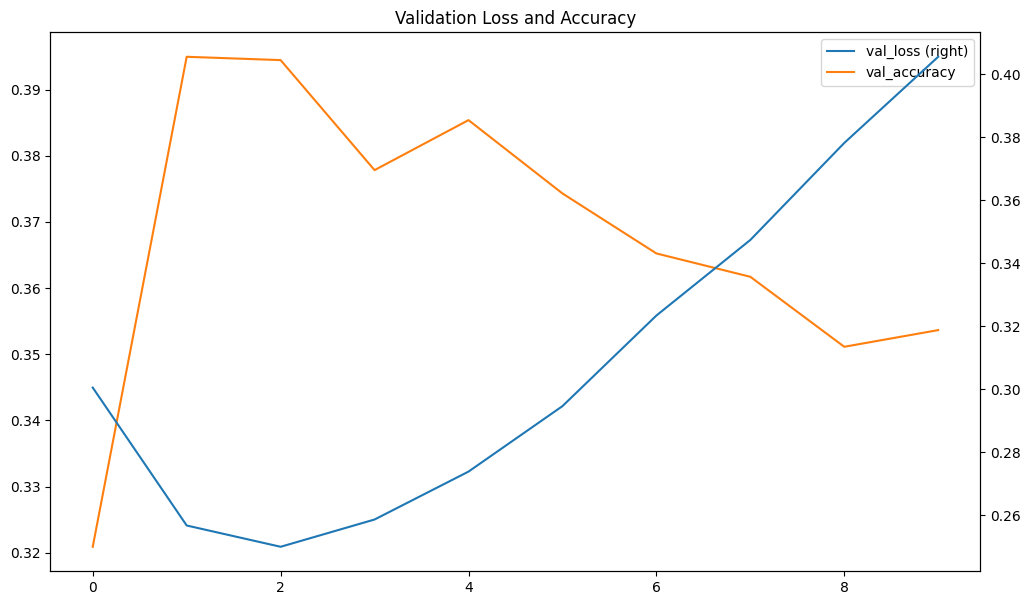

In [117]:
history_df = pd.DataFrame(history.history)
history_df[['val_loss', 'val_accuracy']].plot(
    figsize=(12, 7), secondary_y='val_loss', title="Validation Loss and Accuracy"
)

## Part 3: f1 score

- While modeling is more difficult in the multilabel case, the metrics are, oddly, simpler. Here, we can only compute metrics class by class.
- For each class, print the accuracy and f1 score for the class. Comment on the results. 

In [118]:
preds = model.predict(x_test.toarray())

# Apply a threshold of 0.5 to convert probabilities to binary predictions
preds_binary = (preds >= 0.5).astype(int)

# See predictions for the first two articles
print(preds[:2])
print(preds_binary[:2])

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
[[2.72720399e-07 5.86435020e-01 1.17574395e-08 7.29108346e-04
  9.98486280e-01 1.07903196e-03 1.34821789e-06 5.02874059e-07
  1.16246446e-09 1.31560837e-05 1.64577123e-05 2.80675181e-06]
 [3.95638126e-05 6.44645723e-08 3.08533898e-04 4.96862303e-05
  1.10233586e-07 3.70146183e-04 4.87630023e-05 1.77699585e-05
  2.80601555e-04 5.67175727e-03 9.99984741e-01 1.01572182e-02]]
[[0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


In [119]:
# loop through all the classes
# compute and print the accuracy and f1 for that class
for i, class_ in enumerate(mlb.classes_):
    acc = accuracy_score(y_test[:, i], preds_binary[:, i])
    f1 = f1_score(y_test[:, i], preds_binary[:, i])
    print('Class: {:<20}  Acc: {:.3f}  F1: {:.3f}'.format(class_, acc, f1))

Class: econ.EM               Acc: 0.926  F1: 0.602
Class: econ.GN               Acc: 0.937  F1: 0.601
Class: math.PR               Acc: 0.889  F1: 0.449
Class: q-fin.CP              Acc: 0.893  F1: 0.297
Class: q-fin.EC              Acc: 0.891  F1: 0.556
Class: q-fin.GN              Acc: 0.832  F1: 0.451
Class: q-fin.MF              Acc: 0.874  F1: 0.264
Class: q-fin.PM              Acc: 0.918  F1: 0.472
Class: q-fin.PR              Acc: 0.899  F1: 0.544
Class: q-fin.RM              Acc: 0.910  F1: 0.531
Class: q-fin.ST              Acc: 0.839  F1: 0.579
Class: q-fin.TR              Acc: 0.933  F1: 0.540


Comments:
- The accuracy and F1 scores vary across different classes, indicating that the model performs differently, depending on the category.
- Classes with higher F1 scores suggest better overall performance (good balance between precision and recall), whereas classes with lower F1 scores may indicate a worse balance between precision and recall.
- Discrepancies between accuracy and F1 score for a class may indicate class imbalance or specific prediction patterns.
- We should thus consider focusing on improving performance for classes with lower f1 scores, and investigate potential class imbalance and flawed prediction patterns.

# Problem 3: New Metrics (30%)

In this problem we'll explore new metrics associated with true positives and false positives.

## Part 1: Load the IMDB data and fit a model

 - Load the imdb data
 - Featurize the text using TFIDF
 - Fit logistic regression
 - Calculate the in-sample and out of sample accuracy and f1 score

In [65]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    train_dir = os.path.join(imdb_data_dir, 'train')
    test_dir = os.path.join(imdb_data_dir, 'test')

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)


    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]
    
    return (train_docs, y_train), (test_docs, y_test)

(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('data/aclImdb/')
print('found {} train docs and {} test docs'.format(len(train_docs), len(test_docs)))

found 25000 train docs and 25000 test docs


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [70]:
vec = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train = vec.fit_transform(train_docs)
X_test = vec.transform(test_docs)

# Fit logistic regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# more code here
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print("In sample:")
print('Accuracy: {:.3f}'.format(accuracy_score(y_train, preds_train)))
print('F1: {:.3f}'.format(f1_score(y_train, preds_train)))
print("Out of sample:")
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, preds_test)))
print('F1: {:.3f}'.format(f1_score(y_test, preds_test)))

In sample:
Accuracy: 0.925
F1: 0.926
Out of sample:
Accuracy: 0.882
F1: 0.882


## Part 2: Tradeoff between true positives and false positives

Typically we take a threshold of 0.5 probability to consider something a positive example.
However, as we change this threshold we can change the number of true positives we get.
 - Example: at a theshold of 0.0001 we will get nearly all of the true positives
 - Example: at a threshold of 0.999 we will get almost none of the true positives

Notice: as we change our threshold and increase the number of true positives we will also increase the number of false positives we pick up.

In this part you will create a graph of the false positive rate on the x-axis and the true positive rate on the y-axis. This is often called the `receiver operator characteristic`. Make this curve for the out of sample data below.

Note: while you can use the builtin scikit-learn functionality for this, you will __not receive credit__ if you do. 

In [71]:
from tqdm import tqdm

In [72]:
# your code here
# hint: 
#  - loop through the thresholds
#  - calculate the true positives and false positives

# hint: what values for thresholds should you loop through?
thresholds = np.linspace(0, 1, 100) # We want between 0 and 1
print(thresholds)

# Predict probabilities for the test set
y_probs = model.predict_proba(X_test)[:, 1]

# Initialize lists to store values for ROC curve
true_pos_rates = []
false_pos_rates = []

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

In [73]:
# Loop through and calculate TPR and FPR for each threshold
for threshold in tqdm(thresholds):
    # Get predicted labels based on the threshold
    y_pred = (y_probs >= threshold).astype(int)
    
    # Calculate true positives, false positives, true negatives, false negatives
    tp = np.sum((y_pred == 1) & (y_test == 1))
    fp = np.sum((y_pred == 1) & (y_test == 0))
    tn = np.sum((y_pred == 0) & (y_test == 0))
    fn = np.sum((y_pred == 0) & (y_test == 1))
    
    # Calculate true positive rate (TPR) and false positive rate (FPR)
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    
    # Append the rates to the lists
    true_pos_rates.append(tpr)
    false_pos_rates.append(fpr)

100%|██████████| 100/100 [00:00<00:00, 12013.24it/s]


Text(0.5, 1.0, 'Receiver Operator Characteristic')

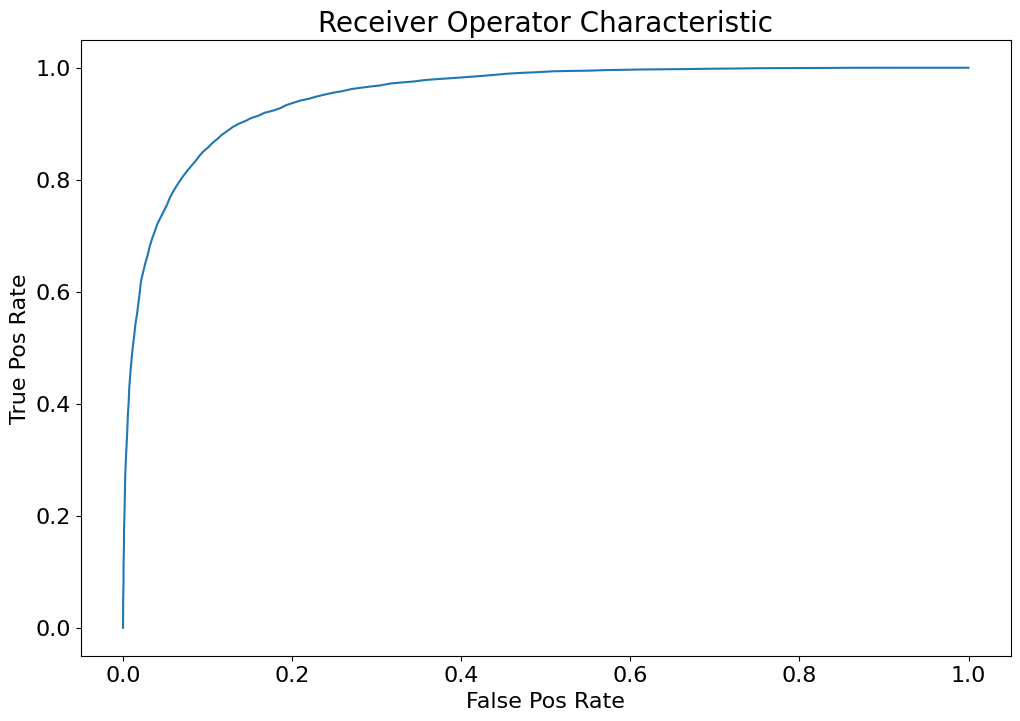

In [74]:
# Show ROC curve
pd.Series(true_pos_rates, index=false_pos_rates).plot(figsize=(12,8), fontsize=16)
plt.xlabel('False Pos Rate', fontsize=16)
plt.ylabel('True Pos Rate', fontsize=16)
plt.title('Receiver Operator Characteristic', fontsize=20)

## Part 3: Baseline

 - What does the receiver operator curve look like for a random guessing classifier? 
 - Make the same plot as above but add the random guessing curve
 - Add comments about WHY the random guessing curve looks this way

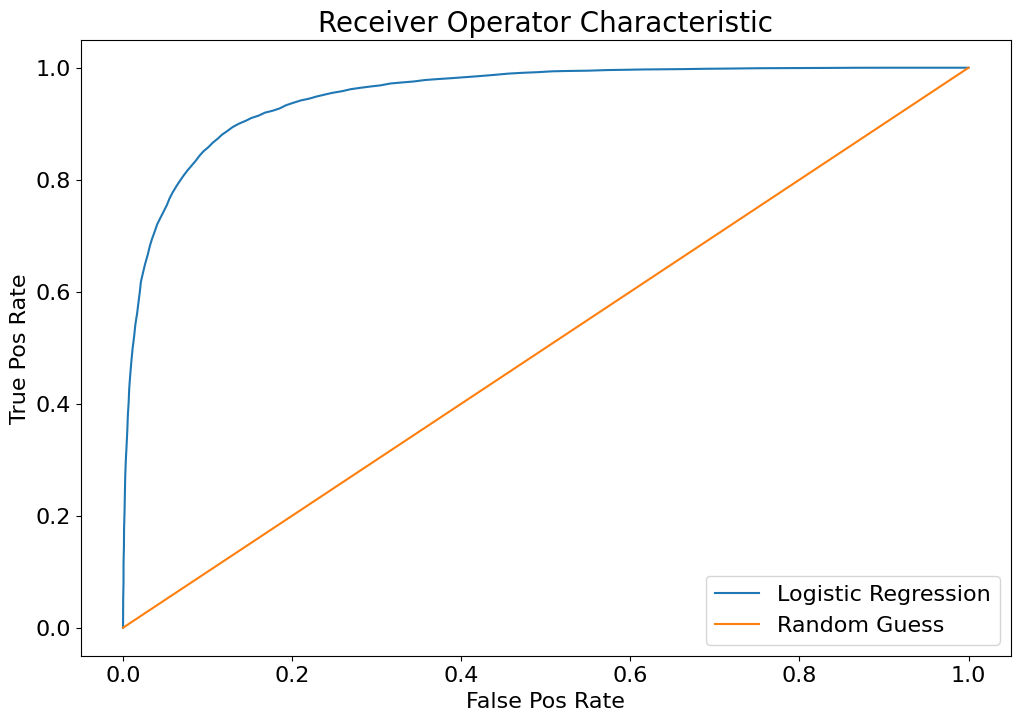

In [75]:
ax = pd.Series(true_pos_rates, index=false_pos_rates, name='Logistic Regression').plot(
    figsize=(12,8), fontsize=16
)

# Create a baseline series for random guessing
# For random guessing, the true positive rate equals the false positive rate
baseline_series = pd.Series(np.linspace(0, 1, len(thresholds)), index=np.linspace(0, 1, len(thresholds)), name='Random Guess')
baseline_series.to_frame('Random Guess').plot(ax=ax, fontsize=16)
plt.xlabel('False Pos Rate', fontsize=16)
plt.ylabel('True Pos Rate', fontsize=16)
plt.title('Receiver Operator Characteristic', fontsize=20)
plt.legend(fontsize=16)

Comments

- The predictive power of a random guess for a binary classification will always be 50%, therefore the ROC graph plots this as a diagonal line where the chance of getting a true positive or false positive is equal.

## Part 4: Boiling it down to a single number

 - While the ROC is a useful curve and contains a lot of information, it is useful to distill in down to a single number. Typically, the area under the curve is used. Calculate the area under the curve and add it as the title to your previous plot. 
 - Hint: think about approximations for integrals for finding area under a curve

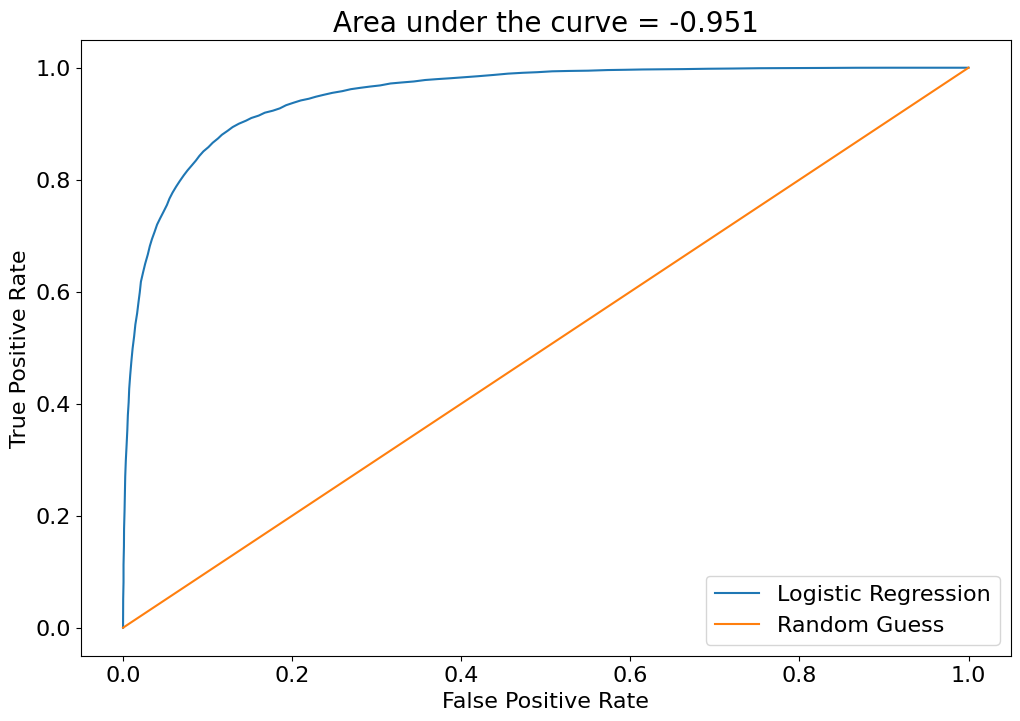

In [86]:
area_under = np.trapz(true_pos_rates, false_pos_rates)
# Breaks the area into small trapezoid and adds them together to calculate the area under the curve

# repeat the plotting code here
ax = pd.Series(true_pos_rates, index=false_pos_rates, name='Logistic Regression').plot(
    figsize=(12, 8), fontsize=16
)
baseline_series = pd.Series(np.linspace(0, 1, len(thresholds)), index=np.linspace(0, 1, len(thresholds)), name='Random Guess')
baseline_series.to_frame('Random Guess').plot(ax=ax, fontsize=16)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Area under the curve = {:.3f}'.format(area_under), fontsize=20)
plt.legend(fontsize=16)
plt.show()

## Part 5: Check you work and comment on the results

 - "There's gotta be a better way!"
 - In fact, `scikit-learn` will take care of a lot of the headache here. 
 - `from sklearn.metrics import plot_roc_curve`
 - read the docs and use this function

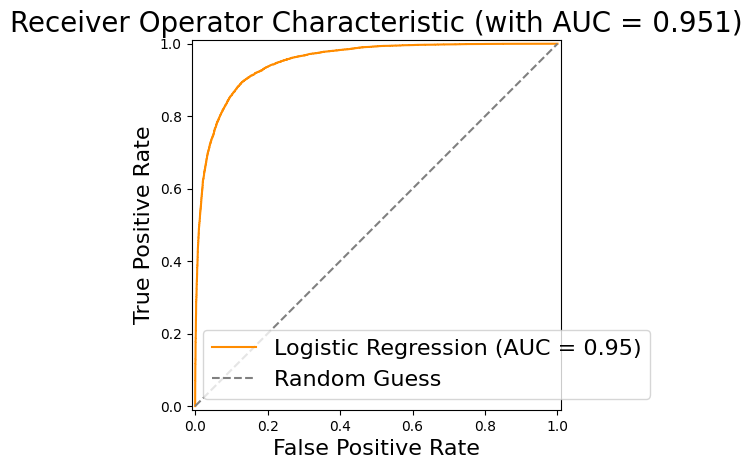

In [78]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# Plot ROC curve using RocCurveDisplay
RocCurveDisplay.from_estimator(model, 
                               X_test, 
                               y_test, 
                               name="Logistic Regression",
                               color="darkorange")

# Add random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Calculate AUC
y_probs = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

# Labels and title
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title(f'Receiver Operator Characteristic (with AUC = {auc:.3f})', fontsize=20)
plt.legend(fontsize=16)
plt.show()

### A few comments:
 - The area under the ROC has a nice interpretation. It can be thought of as the probability that a randomly chosen positive example has a higher probability than a randomly chosen negative example.
 - This metric is also nice since it is independent of a threshold. 

# Problem 4: Examining Coefficients (20%)

In class we skipped an important step: we never made sure our models made sense. 
Logistic regression provides coefficients, which allow us to determine if a model
if learning anything reasonable. 

In this problem, you'll load the imdb data, fit logistic regression and exmamine the coefficients. 
Print out the largest and smallest (largest negative) coefficients and comment on the results.

In [79]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
# copy code from above to load the data
def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    train_dir = os.path.join(imdb_data_dir, 'train')
    test_dir = os.path.join(imdb_data_dir, 'test')

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)


    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]
    
    return (train_docs, y_train), (test_docs, y_test)

In [81]:
(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('data/aclImdb/')
print('found {} train docs and {} test docs'.format(len(train_docs), len(test_docs)))

found 25000 train docs and 25000 test docs


In [82]:
# Same as problem 3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vec = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train = vec.fit_transform(train_docs)
X_test = vec.transform(test_docs)

# Fit logistic regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# more code here
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print("In sample:")
print('Accuracy: {:.3f}'.format(accuracy_score(y_train, preds_train)))
print('F1: {:.3f}'.format(f1_score(y_train, preds_train)))
print("Out of sample:")
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, preds_test)))
print('F1: {:.3f}'.format(f1_score(y_test, preds_test)))

In sample:
Accuracy: 0.925
F1: 0.926
Out of sample:
Accuracy: 0.882
F1: 0.882


In [83]:
# Hint: you can call `vec.get_feature_names` to get the words in order
# that correspond to the columns of the TFIDF matrix 
# This is useful to pass to the index of a pd.Series
feature_names = vec.get_feature_names_out()
coefficients = model.coef_[0]
print(len(feature_names), len(coefficients))
# This is 10000 because we limited the features to 10k in the TFIDF vectorizer

10000 10000


In [85]:
coefs = pd.Series(coefficients, index=feature_names)

# NB: to get the largest items in a series by abs try
#    coefs.loc[coefs.abs().nlargest(20).index]

# Get the 20 largest coefficients by absolute value
largest_coefs = coefs.loc[coefs.abs().nlargest(20).index]

# Print the largest positive and negative coefficients
print("Largest positive coefficients:")
print(largest_coefs[largest_coefs > 0].nlargest(10))
print("\nLargest negative coefficients:")
print(largest_coefs[largest_coefs < 0].nsmallest(10))


Largest positive coefficients:
great        6.222966
excellent    6.012284
best         4.854152
wonderful    4.829100
perfect      4.761972
amazing      4.257827
favorite     4.049532
dtype: float64

Largest negative coefficients:
worst      -8.564540
bad        -6.608441
awful      -6.368621
waste      -5.640938
boring     -5.589781
poor       -5.140937
worse      -4.688937
terrible   -4.432179
dull       -4.399172
poorly     -4.275005
dtype: float64


Comments on the results:

Positive coefficients:
- Words like 'excellent', 'great', 'wonderful', and 'best' are strongly associated with positive reviews, which is intuitive.
- 'Performances' having a high positive coefficient suggests that praising the acting is a common feature of positive reviews.

Negative coefficients:
- 'Worst', 'bad', and 'boring' are unsurprisingly strong indicators of negative reviews.
- 'Waste' (likely in phrases like 'waste of time') is a strong negative predictor.
- Interestingly, 'supposed' has a high negative coefficient, possibly because it's often used in critical contexts (e.g., 'This was supposed to be good, but...')"

Overall, these coefficients align well with intuitive expectations about movie review language, validating the model's ability to capture meaningful sentiment indicators.